In [14]:
# データ解析用ライブラリ
import pandas as pd
import numpy as np
 
# データ可視化用ライブラリ
import matplotlib.pyplot as plt
 
# Scikit-learn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
 
# LightGBM
import lightgbm as lgb

In [15]:
# データの読み込み
df = pd.read_excel(r'concrete.xlsx', sheet_name='concrete', header=0)
# 予測したい変数の設定
Objective_variable = 'Concrete compressive strength'

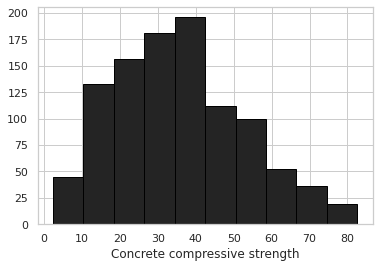

In [16]:
# ヒストグラムの確認
data = np.array(df['Concrete compressive strength'])
plt.hist(data, bins=10, histtype='barstacked', ec='black')
plt.xlabel("Concrete compressive strength")
plt.show()

In [17]:
# スタッキング１段目（Random Forest)
column_name = 'Random_Forest'
 
# training dataの作成
train =  df.drop(Objective_variable, axis=1)
target = df[Objective_variable] 
 
# DataFrameの作成
Train_pred_df = pd.DataFrame(index=df.index, columns=[])
 
# 交差検証の回数
Fold = 10  
 
# 木の深さが異なるモデルによる推定
for i in range(0, 5):
    
    max_depth=(i+1)*2
    kf = KFold(n_splits=Fold, random_state=123, shuffle=True)
    
    pred_df_temp = pd.DataFrame({'index':0, column_name:0}, index=[1])
    pred_df_temp_test = pd.DataFrame({'index':0, column_name:0}, index=[1])
    
    # 交差検証
    for train_index, val_index in kf.split(train, train.index):
        X_train = train.iloc[train_index]
        X_test = train.iloc[val_index]
        y_train = target.iloc[train_index]
        y_test = target.iloc[val_index]
        
        clf = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=max_depth)
        clf = clf.fit(X_train, y_train.values.ravel())
        y_pred = clf.predict(X_test)
        y_pred = pd.DataFrame({'index':y_test.index, column_name:y_pred})
        
        pred_df_temp = pd.concat([pred_df_temp, y_pred], axis=0)
        
    # データの整理
    pred_df_temp = pred_df_temp.sort_values('index').reset_index(drop=True).drop(index=[0]).set_index('index')
    pred_df_temp = pd.concat([pred_df_temp, target], axis=1).rename(columns={str(Objective_variable) : 'true'})
    
    if i == 0:
        Train_pred_df['true'] = pred_df_temp['true']
        Train_pred_df[column_name + '_Maxdepth='+str(max_depth)] = pred_df_temp[column_name]
    else:
        Train_pred_df[column_name + '_Maxdepth='+str(max_depth)] = pred_df_temp[column_name]
 
# 予測値の格納
Random_Forest_train_pred = Train_pred_df

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: 

In [18]:
# 結果の確認
Random_Forest_train_pred

,true,Random_Forest_Maxdepth=2,Random_Forest_Maxdepth=4,Random_Forest_Maxdepth=6,Random_Forest_Maxdepth=8,Random_Forest_Maxdepth=10
0,79.99,51.042916,56.580535,60.519716,61.097678,61.304447
1,61.89,54.337755,60.902473,67.099533,70.754393,73.134610
2,40.27,41.103376,41.153923,44.459895,41.654735,41.297728
3,41.05,41.103376,41.153923,44.488161,41.797938,41.635195
4,44.30,36.989007,38.767007,39.124118,40.608821,40.756458
...,...,...,...,...,...,...
1025,44.28,36.444127,40.586636,42.786786,44.365662,42.884341
1026,31.18,41.319162,40.397077,37.325913,37.409412,38.851236
1027,23.70,32.772280,27.976190,26.494400,25.692295,25.882177
1028,32.77,36.642609,31.323645,34.154323,33.638025,33.379657


In [19]:
# スタッキング１段目（LightGBM)
column_name = 'LightGBM'
 
# パラメータの設定
params = { 'objective': 'regression',
           'metric': 'rmse'}
 
# training dataの作成
train =  df.drop(Objective_variable, axis=1)
target = df[Objective_variable]
 
# DataFrameの作成
Train_pred_df = pd.DataFrame(index=df.index, columns=[])
 
# 交差検証の回数
Fold = 10  
 
# 反復学習回数の異なるモデルによる推定
for i in range(0, 3):
 
    num_boost_round=10**(i+1)
    kf = KFold(n_splits=Fold, shuffle=True, random_state=123)
    
    pred_df_temp = pd.DataFrame({'index':0, column_name:0}, index=[1])
    pred_df_temp_test = pd.DataFrame({'index':0, column_name:0}, index=[1])
    
    for train_index, val_index in kf.split(train, train.index):
        X_train = train.iloc[train_index]
        X_test = train.iloc[val_index]
        y_train = target.iloc[train_index]
        y_test = target.iloc[val_index]
        
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_test, y_test)
 
        clf = lgb.train(params,
                        lgb_train,
                        valid_sets=lgb_eval,
                        num_boost_round=num_boost_round,
                        verbose_eval=50)
        
        y_pred = clf.predict(X_test)
        y_pred = pd.DataFrame({'index':y_test.index, column_name:y_pred})
     
        pred_df_temp = pd.concat([pred_df_temp, y_pred], axis=0)
    
    # データの整理
    pred_df_temp = pred_df_temp.sort_values('index').reset_index(drop=True).drop(index=[0]).set_index('index')
    pred_df_temp = pd.concat([pred_df_temp, target], axis=1).rename(columns={str(Objective_variable) : 'true1'})
    
    if i == 0:
        Train_pred_df['true1'] = pred_df_temp['true1']
        Train_pred_df[column_name + '_num_boost_round='+str(num_boost_round)] = pred_df_temp[column_name]
    else:
        Train_pred_df[column_name + '_num_boost_round='+str(num_boost_round)] = pred_df_temp[column_name]
    
# 予測値の格納
LightGBM_train_pred = Train_pred_df

[50]	valid_0's rmse: 5.58247
[100]	valid_0's rmse: 5.23218
[50]	valid_0's rmse: 5.24779
[100]	valid_0's rmse: 4.83255
[50]	valid_0's rmse: 4.66505
[100]	valid_0's rmse: 4.22983
[50]	valid_0's rmse: 4.00918
[100]	valid_0's rmse: 3.54141
[50]	valid_0's rmse: 4.36362
[100]	valid_0's rmse: 3.911
[50]	valid_0's rmse: 5.01224
[100]	valid_0's rmse: 4.36891
[50]	valid_0's rmse: 4.84883
[100]	valid_0's rmse: 4.41654
[50]	valid_0's rmse: 4.38888
[100]	valid_0's rmse: 4.01504
[50]	valid_0's rmse: 4.39582
[100]	valid_0's rmse: 4.10219
[50]	valid_0's rmse: 4.94963
[100]	valid_0's rmse: 4.44201
[50]	valid_0's rmse: 5.58247
[100]	valid_0's rmse: 5.23218
[150]	valid_0's rmse: 5.10534
[200]	valid_0's rmse: 5.02628
[250]	valid_0's rmse: 4.96948
[300]	valid_0's rmse: 4.93082
[350]	valid_0's rmse: 4.90715
[400]	valid_0's rmse: 4.89238
[450]	valid_0's rmse: 4.88333
[500]	valid_0's rmse: 4.87461
[550]	valid_0's rmse: 4.86861
[600]	valid_0's rmse: 4.8659
[650]	valid_0's rmse: 4.86812
[700]	valid_0's rmse: 4.

In [20]:
# 結果の確認
LightGBM_train_pred

,true1,LightGBM_num_boost_round=10,LightGBM_num_boost_round=100,LightGBM_num_boost_round=1000
0,79.99,47.267885,63.477577,63.247144
1,61.89,51.498371,70.800462,76.598707
2,40.27,43.729739,41.763335,42.194286
3,41.05,43.729739,41.763335,42.194286
4,44.30,38.307434,41.907813,43.419128
...,...,...,...,...
1025,44.28,40.668134,45.925551,45.523627
1026,31.18,38.560427,37.977353,36.853573
1027,23.70,28.891811,26.388195,25.323946
1028,32.77,32.378684,34.196164,33.528668


In [21]:
# スタッキング１段目（重回帰)
column_name = 'Multiple_regression'
 
# 交差検証の回数
Fold = 10  
 
# training dataの作成
train =  df.drop(Objective_variable, axis=1)
target = df[Objective_variable]
 
# DataFrameの作成
Train_pred_df = pd.DataFrame(index=df.index, columns=[])
 
# モデルによる推定
kf = KFold(n_splits=Fold, shuffle=True, random_state=123)
    
pred_df_temp = pd.DataFrame({'index':0, column_name:0}, index=[1])
pred_df_temp_test = pd.DataFrame({'index':0, column_name:0}, index=[1])
    
for train_index, val_index in kf.split(train, train.index):
    X_train = train.iloc[train_index]
    X_test = train.iloc[val_index]
    y_train = target.iloc[train_index]
    y_test = target.iloc[val_index]
       
    clf = linear_model.LinearRegression()
    clf = clf.fit(X_train, y_train.values.ravel())
        
    y_pred = clf.predict(X_test)
    y_pred = pd.DataFrame({'index':y_test.index, column_name:y_pred})
        
    pred_df_temp = pd.concat([pred_df_temp, y_pred], axis=0)
 
# データの整理
pred_df_temp = pred_df_temp.sort_values('index').reset_index(drop=True).drop(index=[0]).set_index('index')
pred_df_temp = pd.concat([pred_df_temp, target], axis=1).rename(columns={str(Objective_variable) : 'true1'})
 
Train_pred_df['true1'] = pred_df_temp['true1']
Train_pred_df[column_name] = pred_df_temp[column_name]
    
# 予測値の格納
Multiple_regression_train_pred = Train_pred_df

In [22]:
# 結果の確認
Multiple_regression_train_pred

,true1,Multiple_regression
0,79.99,52.844757
1,61.89,53.787035
2,40.27,57.680616
3,41.05,68.859903
4,44.30,61.869975
...,...,...
1025,44.28,39.716020
1026,31.18,33.960081
1027,23.70,26.649909
1028,32.77,29.255348


Text(0.5, 1.0, 'Stacking results')

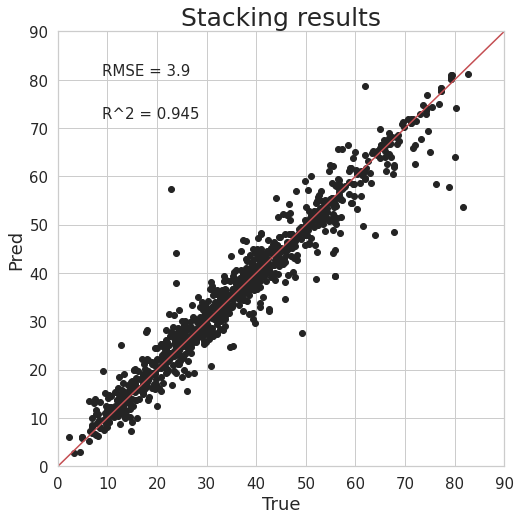

In [23]:
# データの結合
pred_temp = pd.concat([Random_Forest_train_pred, LightGBM_train_pred, Multiple_regression_train_pred],axis=1)
pred_temp = pred_temp.drop('true1', axis=1)

# スタッキング２段目（Ridge回帰)
column_name = 'Stacking'

# training dataの作成
train =  pred_temp.drop('true', axis=1).copy()
target = pred_temp['true'].copy()
 
# DataFrameの作成
Train_pred_df = pd.DataFrame(index=df.index, columns=[])
 
# 交差検証の回数
Fold = 10
 
# 回帰結果の格納
for i in range(0, 1):
    
    kf = KFold(n_splits=Fold, shuffle=True, random_state=123)
    
    pred_df_temp = pd.DataFrame({'index':0, column_name:0}, index=[1])
    
    for train_index, val_index in kf.split(train, train.index):
        X_train = train.iloc[train_index]
        X_test = train.iloc[val_index]
        y_train = target.iloc[train_index]
        y_test = target.iloc[val_index]
 
        clf = linear_model.Ridge(alpha=0.1)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_pred = pd.DataFrame({'index':y_test.index, column_name:y_pred})
        pred_df_temp = pd.concat([pred_df_temp, y_pred], axis=0)
    
    pred_df_temp = pred_df_temp.sort_values('index').reset_index(drop=True).drop(index=[0]).set_index('index')
    pred_df_temp = pd.concat([pred_df_temp, target], axis=1).rename(columns={str(Objective_variable) : 'true'})
    
    if i == 0:
        Train_pred_df['true'] = pred_df_temp['true']
        Train_pred_df[column_name] = pred_df_temp[column_name]
    else:
        Train_pred_df[column_name] = pred_df_temp[column_name]
 
# 予測値の格納
Stacking_train_pred = Train_pred_df
 
#　結果の確認
R2 = r2_score(Stacking_train_pred['true'], Stacking_train_pred['Stacking'])
RMSE = np.sqrt(mean_squared_error(Stacking_train_pred['true'], Stacking_train_pred['Stacking']))    
 
# 図の作成
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
ax.scatter('true', 'Stacking', data=Stacking_train_pred)
ax.set_xlabel('True', fontsize=18)
ax.set_ylabel('Pred', fontsize=18)
ax.set_xlim(0,90)
ax.set_ylim(0,90)
x = np.linspace(0,90, 2)
y = x
ax.plot(x,y,'r-')
plt.text(0.1, 0.8, 'R^2 = {}'.format(str(round(R2, 3))), transform=ax.transAxes, fontsize=15)
plt.text(0.1, 0.9, 'RMSE = {}'.format(str(round(RMSE, 3))), transform=ax.transAxes, fontsize=15)
plt.tick_params(labelsize=15)
plt.title("Stacking results", fontsize=25)

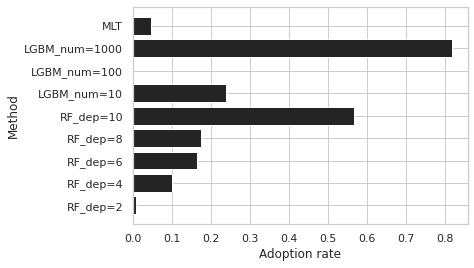

In [24]:
# パッケージのインポート
import seaborn as sns
 
# 偏回帰係数、切片の取得
a = clf.coef_
a = np.abs(a)
b = clf.intercept_  
 
# グラフの作成
sns.set()
sns.set_style('whitegrid')
sns.set_palette('gray')
 
x = np.array(['RF_dep=2','RF_dep=4','RF_dep=6','RF_dep=8','RF_dep=10','LGBM_num=10','LGBM_num=100','LGBM_num=1000','MLT'])
y = a
 
x_position = np.arange(len(x))
 
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.barh(x_position, y, tick_label=x)
ax.set_xlabel('Adoption rate')
ax.set_ylabel('Method')
fig.show()